In [1]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import vectorial_matrices_assembly as assembly
    from fem_processing import gaussian_quadrature, master_domain
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 4: Vectorial Poisson Problem at Rectangular Domain $\Omega = [-1,1]^2$

Considere um problema vetorial de _Poisson_ 2D em $\Omega = [-1,1]^2$

$$
\nabla \times \nabla \times \mathbf{u}(\mathbf{x}) + a \mathbf{u}(\mathbf{x}) =
\mathbf{f}(\mathbf{x}) \quad \text{em} \; \Omega = [-1, 1]^2
\tag{1}
$$

$$
\hat{n} \times \mathbf{u} = 0 \quad \text{em} \; \partial \Omega
$$

onde a fonte é dada por,
$$
\mathbf{f}(x,y) = (2\pi^2 + 1)\, 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{2}
$$

A solução analítica deste problema é

$$
\mathbf{u}(x,y) = 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{3}
$$

# `setTypeProblem()`

In [2]:
def setTypeProblem(FINITE_ELEMENT, h):
    # Create mesh using gmsh
    BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'entire_boundary'}]
    MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]
    
    # Create mesh Structure Data from gmsh
    mesh_data = ps.create_meshed_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h, auto_save=False)
    
    # Get FEM solution
    Sg, fg, Mg = assembly.global_matrices(FINITE_ELEMENT, mesh_data)
    # Apply boundary conditions
    Sg, fg = assembly.apply_simple_dirichlet(Sg, fg, mesh_data)
    # Solução do problema matricial
    curl_uh = spsolve((Sg+Mg).tocsr(), fg.toarray())
    # Criar o dicionário da solução numérica
    curl_uh = {key+1: value for key, value in enumerate(curl_uh)}
    
    return curl_uh, mesh_data

# Convergence Analysis

In [3]:
element_types = [('Triangle', 1)]
u_f_gradu = lambda x, y: ps.set_analytical_solution(x, y)
mesh_sizes = [1 / (2**i) for i in range(1, 5)]

# Inicialização dos dicionários para armazenar erros acumulados para cada tipo de elemento
errors_l2 = {et: [] for et in element_types}

for h in mesh_sizes:  
    for FINITE_ELEMENT in element_types:  
        # Resolve a solução numérica para o tipo de elemento e refinamento de malha
        curl_uh, mesh_data = setTypeProblem(FINITE_ELEMENT, h)  
        
        # Calcula o erro L2, o erro de energia e a energia total
        # ---------------------------------------------- #    

        # Inicializa o somatório do erro L2 para este tipo e refinamento
        error_L2_sum = 0.0  # Reinicia o somatório do erro L2 para este tipo e refinamento

        # Get the Gauss points and weights
        gauss_points, gauss_weights = gaussian_quadrature.gauss_data(FINITE_ELEMENT)

        for key, cell in mesh_data['cell'].items():
            # Get the global coordinates of the nodes
            aie = [mesh_data['nodes'][node]['xg'] for node in cell['conn_sorted']]

            # Calcula o jacobiano e seu determinante
            Je = assembly.jacobian(mesh_data, cell) 
            Jdet = np.abs(np.linalg.det(Je))        
            JinvT = np.linalg.inv(Je).T

            # Integração numérica com a regra de quadratura de Gauss    
            for i, (xik, wk) in enumerate(zip(gauss_points, gauss_weights)):
                # Mapeamento isoparamétrico de coordenadas locais (xik) para coordenadas globais (xg, yg)
                varphi = master_domain.shape_functions_p1(*xik)
                xge = sum(Ni * aie[i] for i, Ni in enumerate(varphi))

                # Calcula a solução vetorial exata no ponto de Gauss
                u_at_xik = ps.set_analytical_solution(*xge)[0]

                # Função de forma vetorial no ponto de Gauss    
                phi_hat = master_domain.shape_functions_n0(*xik)

                # Interpolação dos potenciais vetoriais em cada célula
                uh_at_xik = 0
                for i, edge in enumerate(cell['conn_edge']):
                    uh_at_xik += curl_uh[edge].real * (JinvT @ phi_hat[i])

                # Calcula o erro quadrático L2 no ponto de Gauss
                error_squared = (np.linalg.norm(u_at_xik) - np.linalg.norm(uh_at_xik)) ** 2

                # Acumula os erros L2 e de energia
                error_L2_sum += wk * error_squared * Jdet
        
        l2 = np.sqrt(error_L2_sum)

        # ---------------------------------------------- #
        # Acumula os erros nos dicionários correspondentes
        errors_l2[FINITE_ELEMENT].append(l2)


# Figure 1: Convergence of the numerical solution for $L_2$ norm of the error

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_problem\pos_processing\pictures\convergence_L2.svg


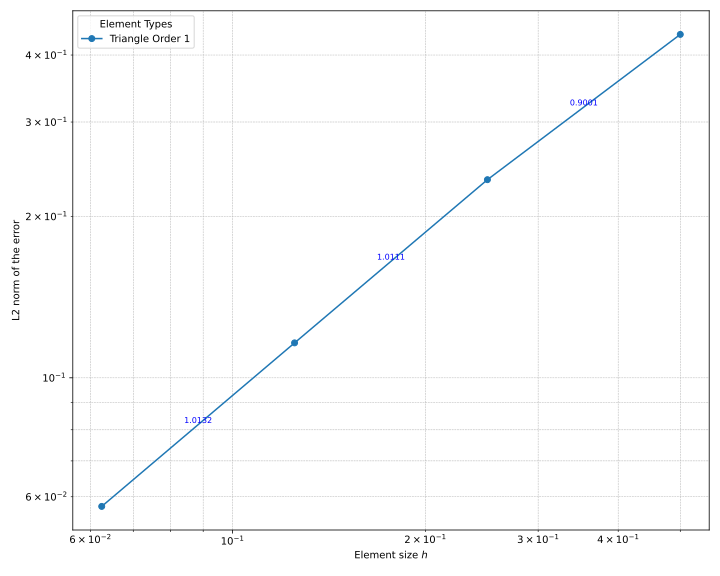

In [4]:
graph_results.plot_convergence(mesh_sizes, errors_l2, type='L2')
display(SVG(filename="pos_processing/pictures/convergence_L2.svg"))

# Convergence Order, $\alpha$

In [5]:
error_list = errors_l2[('Triangle', 1)]
alpha_values = []
for i in range(len(error_list) - 1):
    alpha_values.append(np.log(error_list[i] / error_list[i + 1]) / np.log(2))

# Exibe os valores estimados de alfa
print("Ordem de convergência (α) para cada par de refinamentos de malha:")
for i, alpha in enumerate(alpha_values, 1):
    print(f"Refinamento h_{i} -> h_{i+1}: α = {alpha:.4f}")


Ordem de convergência (α) para cada par de refinamentos de malha:
Refinamento h_1 -> h_2: α = 0.9001
Refinamento h_2 -> h_3: α = 1.0111
Refinamento h_3 -> h_4: α = 1.0132


Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.